In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import bambi as bmb
from sklearn.metrics import confusion_matrix
from scipy.special import expit
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [4]:
data["vote"].value_counts()

vote
clinton         215
trump           158
someone_else     48
Name: count, dtype: int64

In [5]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [6]:
clinton_model = bmb.Model("vote['clinton'] ~ age", clinton_data, family="bernoulli")

In [7]:
clinton_fitted = clinton_model.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

Modeling the probability that vote==clinton


Compiling...


Compilation time =  0:00:04.605319
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.626015
Transforming variables...
Transformation time =  0:00:00.004268
Computing Log Likelihood...


Log Likelihood time =  0:00:00.314929


In [8]:
clinton_model

       Formula: vote['clinton'] ~ age
        Family: bernoulli
          Link: p = logit
  Observations: 373
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 7.586)
            age ~ Normal(mu: 0.0, sigma: 0.1454)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Intercept, age]


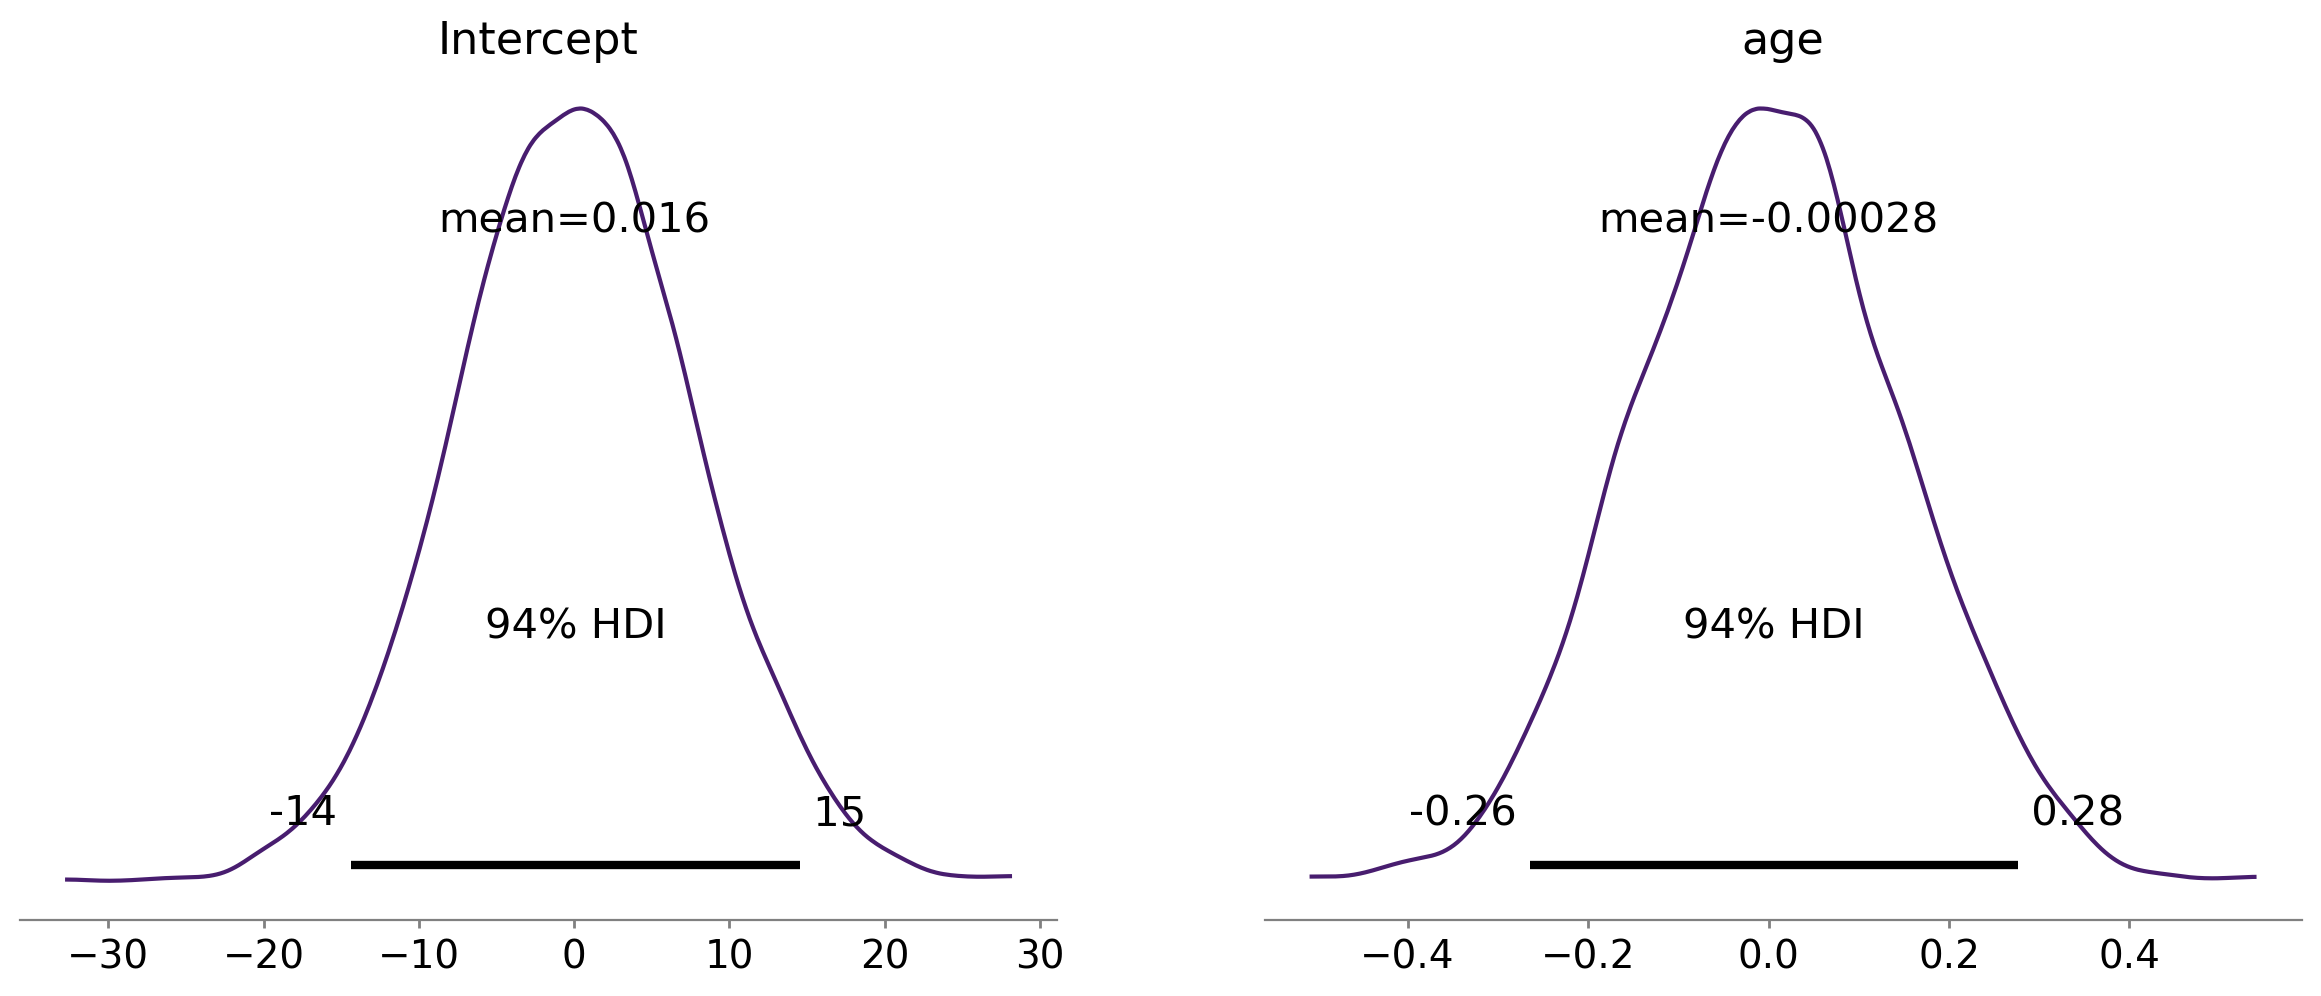

In [9]:
clinton_model.plot_priors()
plt.show()

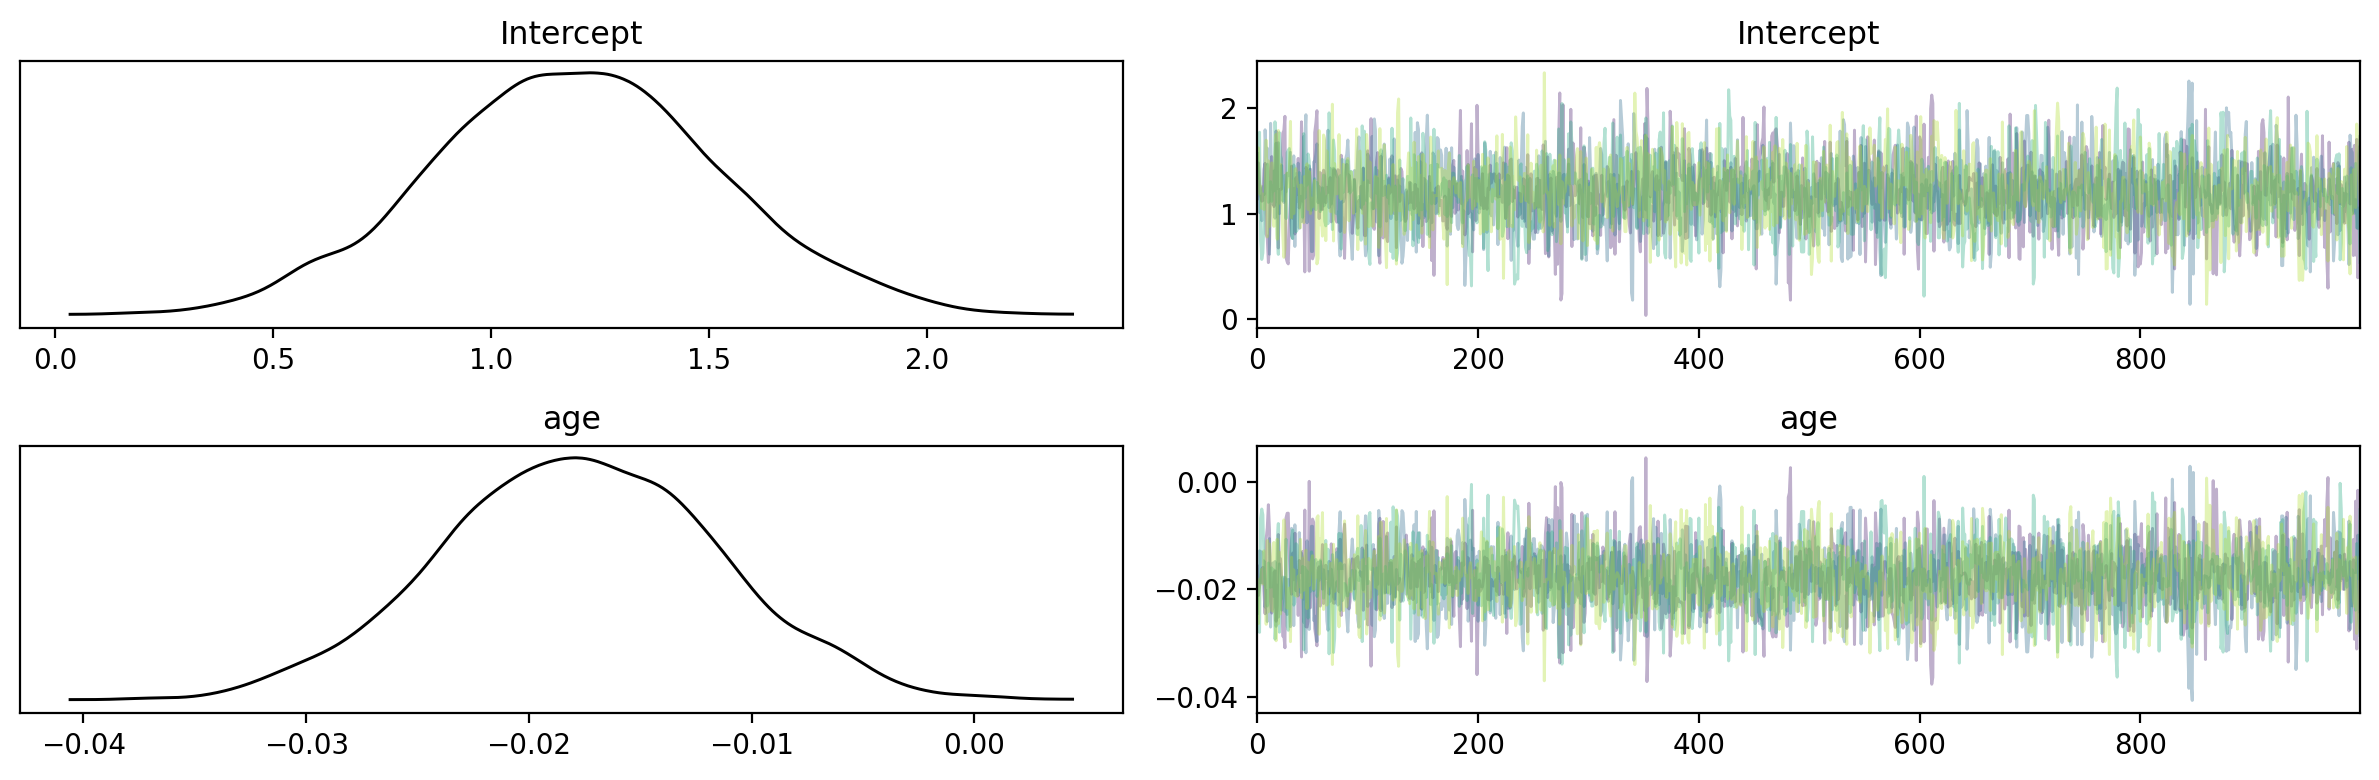

In [10]:
az.plot_trace(clinton_fitted, combined=True, compact=False)
plt.tight_layout()
plt.show()

In [11]:
posterior_predictive = clinton_model.predict(clinton_fitted, kind="pps")

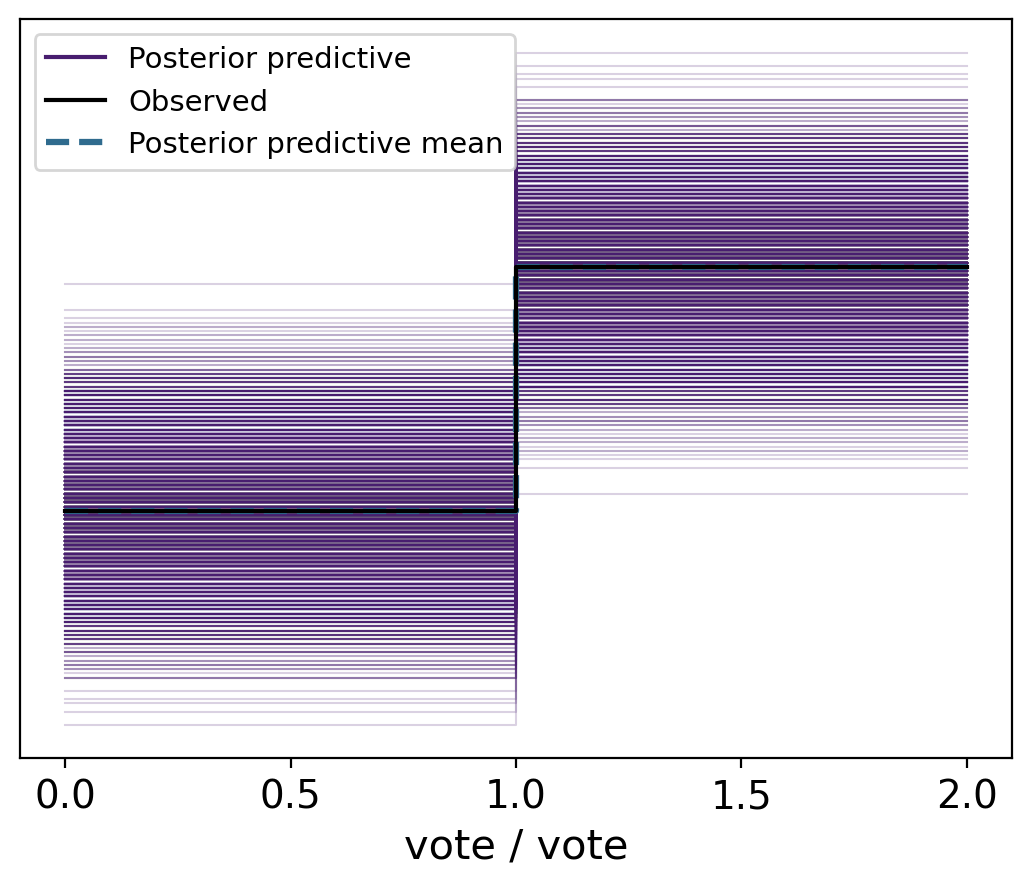

In [12]:
az.plot_ppc(clinton_fitted)
plt.show()

In [13]:
loo = az.loo(clinton_fitted, pointwise=True)

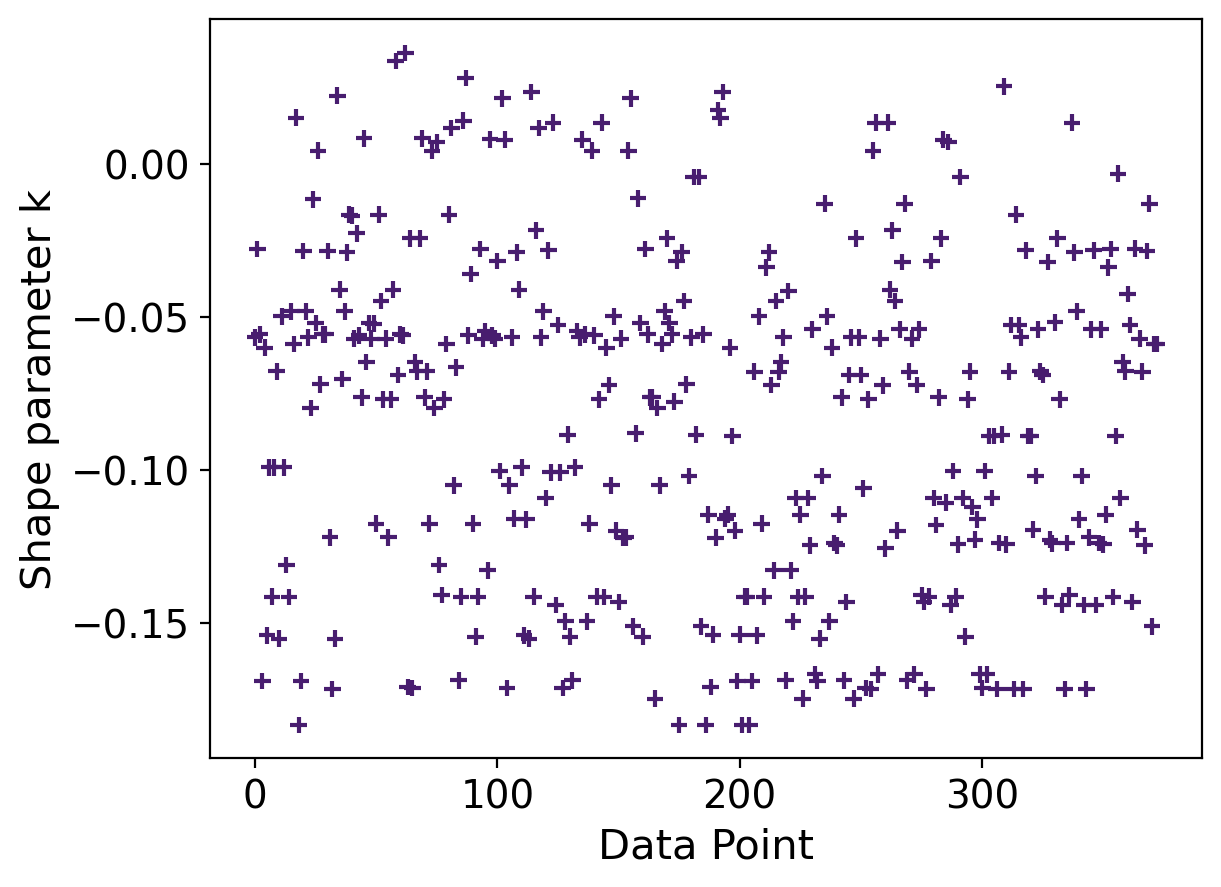

In [14]:
az.plot_khat(loo.pareto_k)
plt.show()

In [15]:
summary_df = az.summary(clinton_fitted)
print(summary_df)

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       1.192  0.330   0.564    1.813      0.005    0.004    3658.0   
age            -0.018  0.006  -0.029   -0.005      0.000    0.000    4026.0   
vote_mean[0]    0.549  0.028   0.495    0.600      0.000    0.000    3159.0   
vote_mean[1]    0.509  0.035   0.444    0.574      0.001    0.000    3571.0   
vote_mean[2]    0.443  0.052   0.347    0.542      0.001    0.001    3970.0   
...               ...    ...     ...      ...        ...      ...       ...   
vote_mean[368]  0.605  0.028   0.553    0.657      0.001    0.000    2967.0   
vote_mean[369]  0.592  0.026   0.542    0.640      0.000    0.000    2936.0   
vote_mean[370]  0.514  0.034   0.453    0.580      0.001    0.000    3530.0   
vote_mean[371]  0.622  0.030   0.566    0.678      0.001    0.000    3061.0   
vote_mean[372]  0.622  0.030   0.566    0.678      0.001    0.000    3061.0   

                ess_tail  r_hat  
Intercept        

In [16]:
beta_0 = summary_df.loc['Intercept', 'mean']
print(beta_0)

1.192


In [17]:
np.exp(beta_0)

3.2936619483452665

In [18]:
np.exp(beta_0) / (1 + np.exp(beta_0))

0.7670985717947847

In [19]:
beta_1 = summary_df.loc['age', 'mean']
print(beta_1)

-0.018


In [20]:
np.exp(beta_1)

0.9821610323583008

In [21]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3)
})
new_data

,age
0,18
1,19
2,20
3,21
4,22
...,...
214,86
215,87
216,88
217,89


In [22]:
clinton_model.predict(clinton_fitted, data=new_data)

In [23]:
vote_posterior = az.extract(clinton_fitted, num_samples=2000)["vote_mean"]
vote_posterior.shape

(219, 2000)

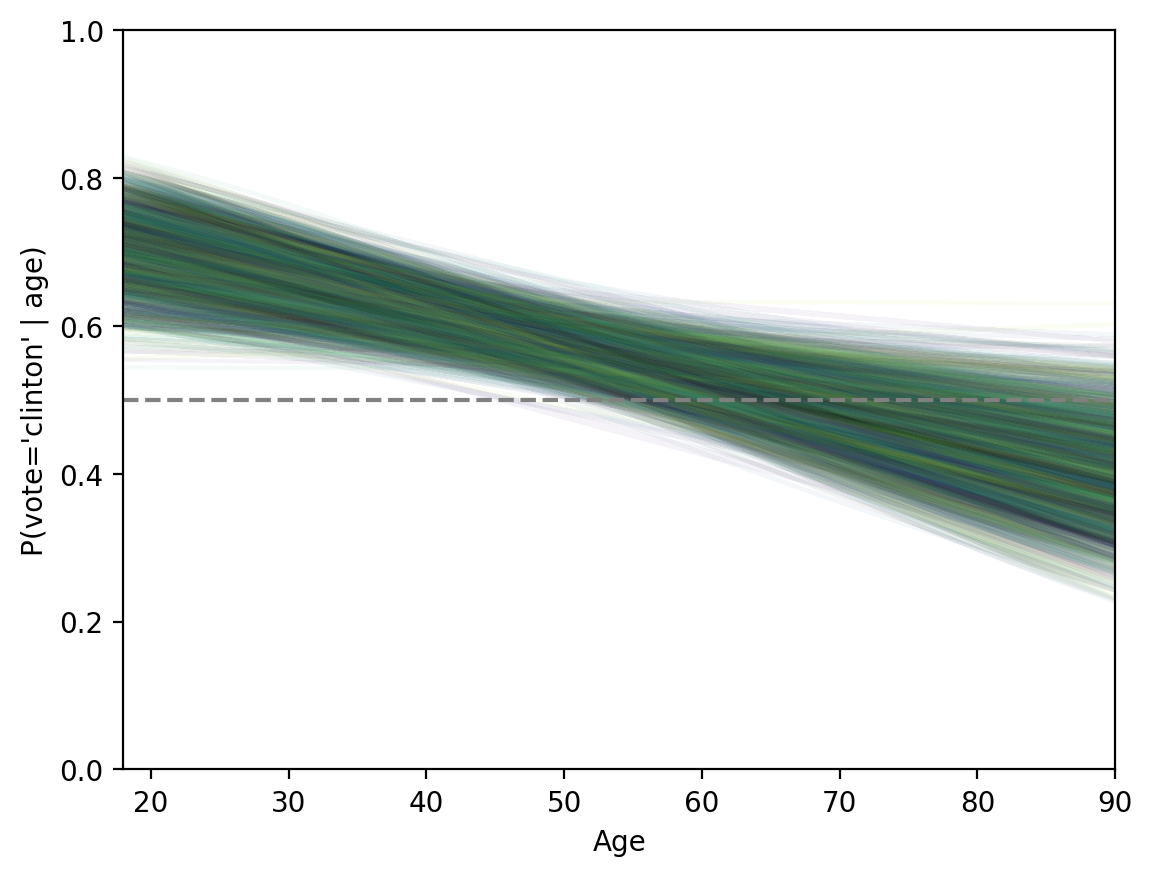

In [24]:
plt.plot(new_data.age, vote_posterior, alpha=0.05)

# Adding a dashed horizontal line at y=0.5 (50% probability)
plt.axhline(y=0.5, color="gray", linestyle="dashed")

plt.ylabel("P(vote='clinton' | age)")
plt.xlabel("Age")
plt.ylim(0, 1)
plt.xlim(18, 90);

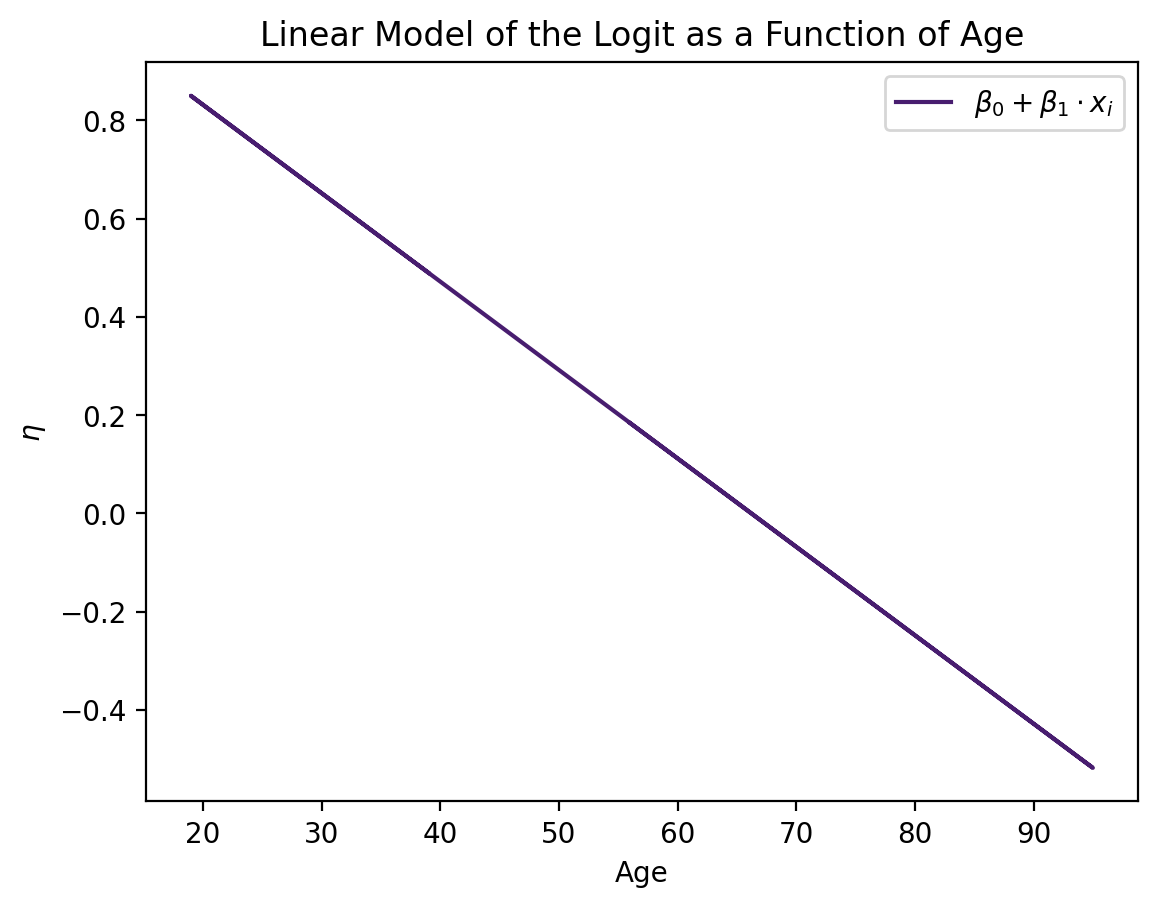

In [25]:
eta = beta_0 + beta_1 * clinton_data["age"]

plt.figure()
plt.plot(clinton_data["age"], eta, label=r"$\beta_0 + \beta_1 \cdot x_i$")
plt.xlabel("Age")  # Label for the x-axis
plt.ylabel(r"$\eta$")  # Label for the y-axis
plt.title("Linear Model of the Logit as a Function of Age")  # Title for the plot
plt.legend()
plt.show()

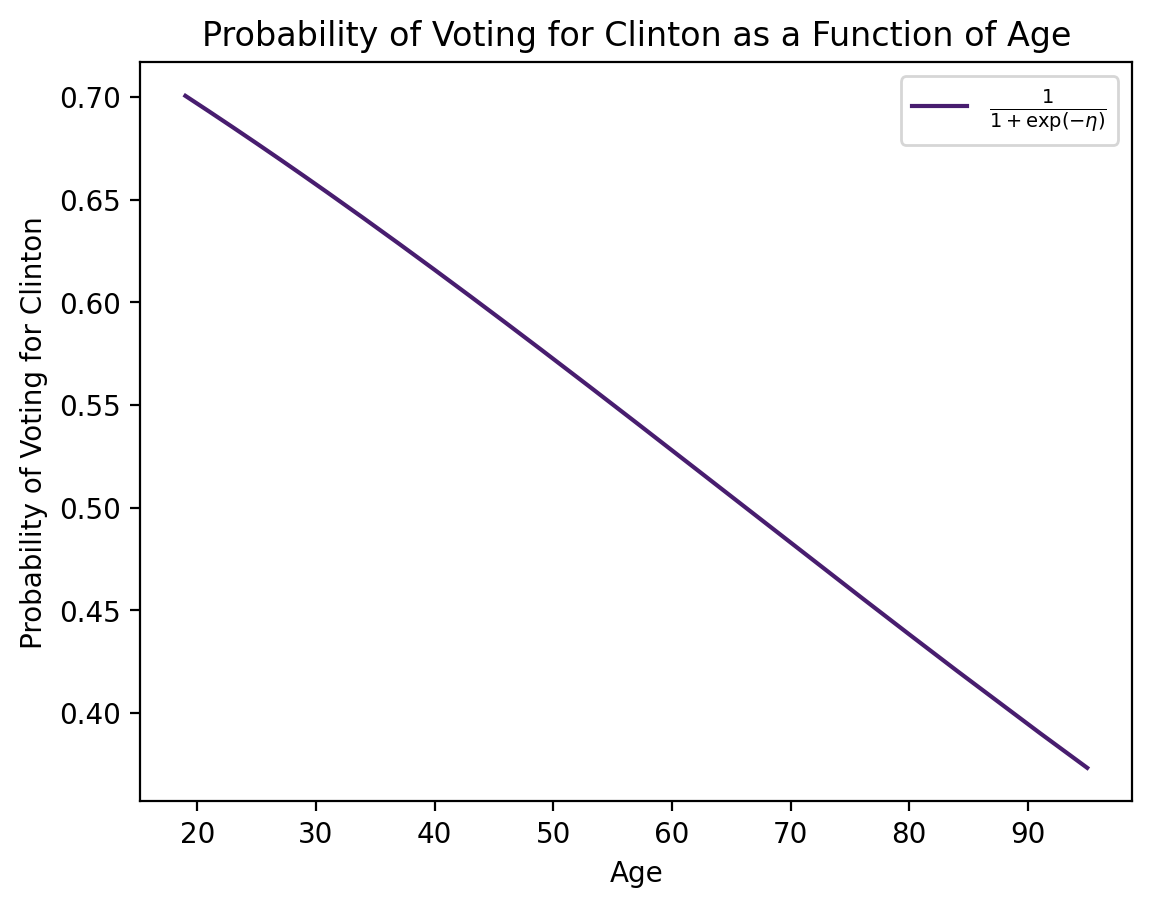

In [26]:
# Sort the age data first
sorted_age = np.sort(clinton_data["age"])

# Calculate eta using the sorted ages
eta_sorted = beta_0 + beta_1 * sorted_age

# Compute the sigmoid function
p_true_sorted = 1 / (1 + np.exp(-eta_sorted))

# Now, plot the sigmoid curve
plt.figure()
plt.plot(sorted_age, p_true_sorted, label=r"$\frac{1}{1 + \exp(-\eta)}$")
plt.xlabel("Age")
plt.ylabel(r"Probability of Voting for Clinton")  
plt.title("Probability of Voting for Clinton as a Function of Age")
plt.legend()
plt.show()

In [27]:
clinton_model.predict(clinton_fitted)

In [28]:
print(clinton_fitted.posterior["vote_mean"])

<xarray.DataArray 'vote_mean' (chain: 4, draw: 1000, vote_obs: 373)>
array([[[0.56524056, 0.5303047 , 0.47158462, ..., 0.53420756,
         0.6292414 , 0.6292414 ],
        [0.5737839 , 0.52676378, 0.44775213, ..., 0.53202738,
         0.65846841, 0.65846841],
        [0.55139527, 0.5078657 , 0.43537799, ..., 0.51272039,
         0.63101447, 0.63101447],
        ...,
        [0.57461681, 0.57111534, 0.56526386, ..., 0.57150475,
         0.58121005, 0.58121005],
        [0.59235811, 0.56149549, 0.50910381, ..., 0.56495287,
         0.648544  , 0.648544  ],
        [0.5691686 , 0.51523795, 0.42518807, ..., 0.52127119,
         0.66580514, 0.66580514]],

       [[0.54992307, 0.49505292, 0.40451107, ..., 0.501168  ,
         0.64935303, 0.64935303],
        [0.5968442 , 0.56131274, 0.50085554, ..., 0.56529893,
         0.66101295, 0.66101295],
        [0.57197357, 0.54348305, 0.49545365, ..., 0.54666626,
         0.62437055, 0.62437055],
...
        [0.55909868, 0.52818143, 0.47628764, ...

In [29]:
probs_array = clinton_fitted.posterior["vote_mean"]
average_posterior_values = probs_array.mean(dim=("chain", "draw"))
clinton_data["probs"] = average_posterior_values.values
clinton_data.head()

,vote,age,party_id,probs
0,clinton,56,democrat,0.548818
1,trump,65,republican,0.509099
2,clinton,80,democrat,0.443392
3,trump,38,republican,0.625798
4,trump,60,republican,0.531200


In [30]:
clinton_data["predicted"] = (clinton_data["probs"] > 0.5).astype(int);

In [31]:
clinton_data["actual"] = (clinton_data["vote"] == "clinton").astype(int)

In [32]:
confusion = confusion_matrix(clinton_data["actual"], clinton_data["predicted"])
print(confusion)

[[ 28 130]
 [ 27 188]]


In [33]:
(33 + 184) / (33 + 125 + 31 + 184)

0.5817694369973191

In [34]:
184/ (31+184)

0.8558139534883721

In [35]:
33 / (33+125)

0.2088607594936709

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

arviz     : 0.16.0
matplotlib: 3.7.2
pandas    : 2.0.3
bambi     : 0.12.0
seaborn   : 0.12.2
numpy     : 1.25.2

Watermark: 2.4.3

